In [1]:
%cd ..

/home/feodor/Jupyter/depth-poset


/home/feodor/.local/lib/python3.12/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
import os

import numpy as np
import pandas as pd
import pickle as pkl
import networkx as nx
import gudhi as gh

from src.depth import DepthPoset


#from tqdm.notebook import tqdm
from tqdm import tqdm

from matplotlib import pyplot as plt
from matplotlib import cm
from networkx import draw_networkx
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from matplotlib import lines as mlines

from src.depth import DepthPoset

# Load and Format the Data

In [3]:
# define file paths
directory = "results/scores-on-barycentric-cubical-toruses"
paths = np.sort([f'{directory}/{f}' for f in os.listdir(directory)])

paths = paths[pd.Series(paths).apply(lambda s: s.split('.')[0].split('/')[-1]).values > '2024-12-26 18:04:00']

# load them
ls = []
for path in tqdm(paths, total=len(paths)):
    with open(path, 'rb') as file:
        ls.append(pkl.load(file))
        ls[-1].update({'path': path})

100%|██████████| 29/29 [00:00<00:00, 166.30it/s]


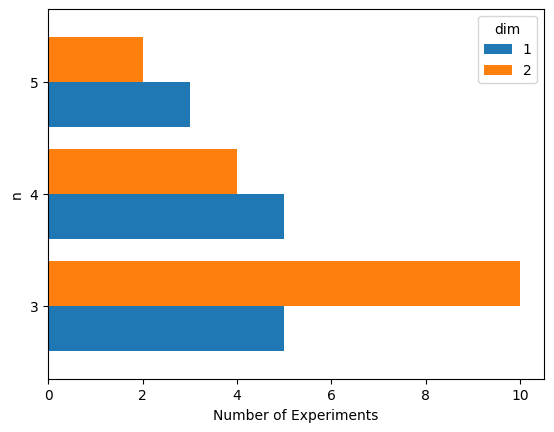

In [4]:
df_cases = pd.DataFrame(ls)
df_cases.insert(0, 'index', df_cases.index)

df_cases[['n', 'dim', 'depth poset']].groupby(['n', 'dim']).count().reset_index().pivot(columns='dim', index='n', values='depth poset').fillna(0).astype(int).plot(kind='barh', width=0.8)
plt.xlabel('Number of Experiments')
plt.savefig('raports/pics/torus scores - cases.png')

In [5]:
print(f'df_cases.shape = {df_cases.shape}')
df_cases.head()

df_cases.shape = (29, 9)


,index,n,dim,shape,complex,depth poset,poset scores,node scores,path
0,0,3,2,"(3, 3)",<src.complexes.CubicalTorusComplex object at 0...,<src.depth.DepthPoset object at 0x7009a1d65400>,"[{'object': 'full', 'avarage_maximal_chain': 2...","[{'object': 'full', 'node': (0, 2),((2,2),(0,2...",results/scores-on-barycentric-cubical-toruses/...
1,1,3,2,"(3, 3)",<src.complexes.CubicalTorusComplex object at 0...,<src.depth.DepthPoset object at 0x7009a23bd580>,"[{'object': 'full', 'avarage_maximal_chain': 2...","[{'object': 'full', 'node': (0, 2),((0,2),(1,2...",results/scores-on-barycentric-cubical-toruses/...
2,2,3,2,"(3, 3)",<src.complexes.CubicalTorusComplex object at 0...,<src.depth.DepthPoset object at 0x7009a1d66120>,"[{'object': 'full', 'avarage_maximal_chain': 2...","[{'object': 'full', 'node': (1, 1),((1,0),(1,1...",results/scores-on-barycentric-cubical-toruses/...
3,3,3,2,"(3, 3)",<src.complexes.CubicalTorusComplex object at 0...,<src.depth.DepthPoset object at 0x7009a1d65550>,"[{'object': 'full', 'avarage_maximal_chain': 2...","[{'object': 'full', 'node': (1, 0),((0,2),(1,2...",results/scores-on-barycentric-cubical-toruses/...
4,4,3,2,"(3, 3)",<src.complexes.CubicalTorusComplex object at 0...,<src.depth.DepthPoset object at 0x7009a1cebe90>,"[{'object': 'full', 'avarage_maximal_chain': 2...","[{'object': 'full', 'node': (1, 0),((0,1),(1,1...",results/scores-on-barycentric-cubical-toruses/...


## Geting pairs for homotopies

In [6]:
import itertools

In [7]:
max_pairs = 30

pairs = df_cases.groupby(['dim', 'shape'])['path'].agg(lambda l: np.array(list(itertools.combinations(l, 2))))
pairs = pairs.apply(lambda l: l if len(l) <= max_pairs else l[np.sort(np.random.choice(np.arange(len(l)), max_pairs, replace=False))])
pairs = np.concatenate(pairs.values)

print(f'pairs.shape = {pairs.shape}')
pairs[:5]

pairs.shape = (60, 2)


array([['results/scores-on-barycentric-cubical-toruses/2025-06-13 16:36:03.991235.pkl',
        'results/scores-on-barycentric-cubical-toruses/2025-06-13 16:36:05.714668.pkl'],
       ['results/scores-on-barycentric-cubical-toruses/2025-06-13 16:36:03.991235.pkl',
        'results/scores-on-barycentric-cubical-toruses/2025-06-13 16:36:07.004147.pkl'],
       ['results/scores-on-barycentric-cubical-toruses/2025-06-13 16:36:03.991235.pkl',
        'results/scores-on-barycentric-cubical-toruses/2025-06-13 16:36:08.249180.pkl'],
       ['results/scores-on-barycentric-cubical-toruses/2025-06-13 16:36:03.991235.pkl',
        'results/scores-on-barycentric-cubical-toruses/2025-06-13 16:36:09.966217.pkl'],
       ['results/scores-on-barycentric-cubical-toruses/2025-06-13 16:36:05.714668.pkl',
        'results/scores-on-barycentric-cubical-toruses/2025-06-13 16:36:07.004147.pkl']],
      dtype='<U76')

# Plot Poset Scores

In [8]:
from src import poset_scores

In [9]:
df_poset_scores = [pd.DataFrame(i['poset scores']) for i in ls]
for i in range(len(df_poset_scores)):
    df_poset_scores[i].insert(0, 'index', value=i)
df_poset_scores = pd.concat(df_poset_scores)

df_poset_scores = df_cases[['index', 'n', 'dim']].join(df_poset_scores.set_index('index'), on='index')
df_poset_scores = df_poset_scores.reset_index(drop=True)

print(f'df_poset_scores.shape = {df_poset_scores.shape}')
df_poset_scores.head(12)

df_poset_scores.shape = (222, 16)


,index,n,dim,object,avarage_maximal_chain,cycles_dimension,height,minimum_maximal_chain,number_of_components,number_of_edges_in_closure,number_of_edges_in_reduction,number_of_maximal_nodes,number_of_minimal_nodes,number_of_nodes,number_of_relations,width
0,0,3,2,full,2.300000,1,3,1,6,18,11,6,9,16,11,9
1,0,3,2,subposet dim=0,2.250000,0,3,1,3,9,5,3,4,8,5,4
2,0,3,2,subposet dim=1,2.333333,1,2,1,3,9,6,3,5,8,6,5
3,0,3,2,column reduction,1.583333,0,2,1,10,9,6,10,12,16,6,12
4,0,3,2,column reduction subposet dim=0,1.142857,0,1,1,7,1,1,7,7,8,1,7
5,0,3,2,column reduction subposet dim=1,2.200000,0,2,1,3,8,5,3,5,8,5,5
6,0,3,2,row reduction,1.545455,0,3,1,10,9,6,10,11,16,6,11
7,0,3,2,row reduction subposet dim=0,2.000000,0,3,1,4,7,4,4,4,8,4,4
8,0,3,2,row reduction subposet dim=1,1.285714,0,1,1,6,2,2,6,7,8,2,7
9,1,3,2,full,2.333333,0,4,1,5,19,11,6,8,16,11,8


In [10]:
interesting_poset_scores = [poset_scores.number_of_nodes, 
                            poset_scores.number_of_relations, 
                            poset_scores.number_of_components, 
                            poset_scores.cycles_dimension, 
                            poset_scores.number_of_minimal_nodes, 
                            poset_scores.number_of_maximal_nodes, 
                            poset_scores.height, 
                            poset_scores.width, 
                            poset_scores.minimum_maximal_chain, 
                            poset_scores.avarage_maximal_chain
                           ]
interesting_poset_scores_names = [score.__name__ for score in interesting_poset_scores]

for score in interesting_poset_scores:
    if not (score.__name__ in df_poset_scores.columns):
        df_poset_scores[score.__name__] = np.nan

missed_values = df_poset_scores[[score.__name__ for score in interesting_poset_scores]].isna().sum().sum()
print(f'There are {missed_values} values missed and should be restored.')

with tqdm(total=missed_values) as pbar:
    for i in df_poset_scores[df_poset_scores[interesting_poset_scores_names].isna().any(axis=1)].index:
        if df_poset_scores.loc[i, interesting_poset_scores_names].isna().any():
            dp = df_cases.loc[df_cases['index'] == df_poset_scores.loc[i, 'index'], 'depth poset'].values[0]
            if df_poset_scores.loc[i, 'object'] != 'full':
                dim = int(df_poset_scores.loc[i, 'object'].replace('subposet dim=', ''))
                dp = dp.subposet_dim(dim)
            for score in interesting_poset_scores:
                if pd.isna(df_poset_scores.loc[i, score.__name__]):
                    df_poset_scores.loc[i, score.__name__] = score(dp)
                    pbar.update()
        
print(f'df_poset_scores.shape = {df_poset_scores.shape}')
df_poset_scores.head()

There are 0 values missed and should be restored.


0it [00:00, ?it/s]

df_poset_scores.shape = (222, 16)


,index,n,dim,object,avarage_maximal_chain,cycles_dimension,height,minimum_maximal_chain,number_of_components,number_of_edges_in_closure,number_of_edges_in_reduction,number_of_maximal_nodes,number_of_minimal_nodes,number_of_nodes,number_of_relations,width
0,0,3,2,full,2.300000,1,3,1,6,18,11,6,9,16,11,9
1,0,3,2,subposet dim=0,2.250000,0,3,1,3,9,5,3,4,8,5,4
2,0,3,2,subposet dim=1,2.333333,1,2,1,3,9,6,3,5,8,6,5
3,0,3,2,column reduction,1.583333,0,2,1,10,9,6,10,12,16,6,12
4,0,3,2,column reduction subposet dim=0,1.142857,0,1,1,7,1,1,7,7,8,1,7


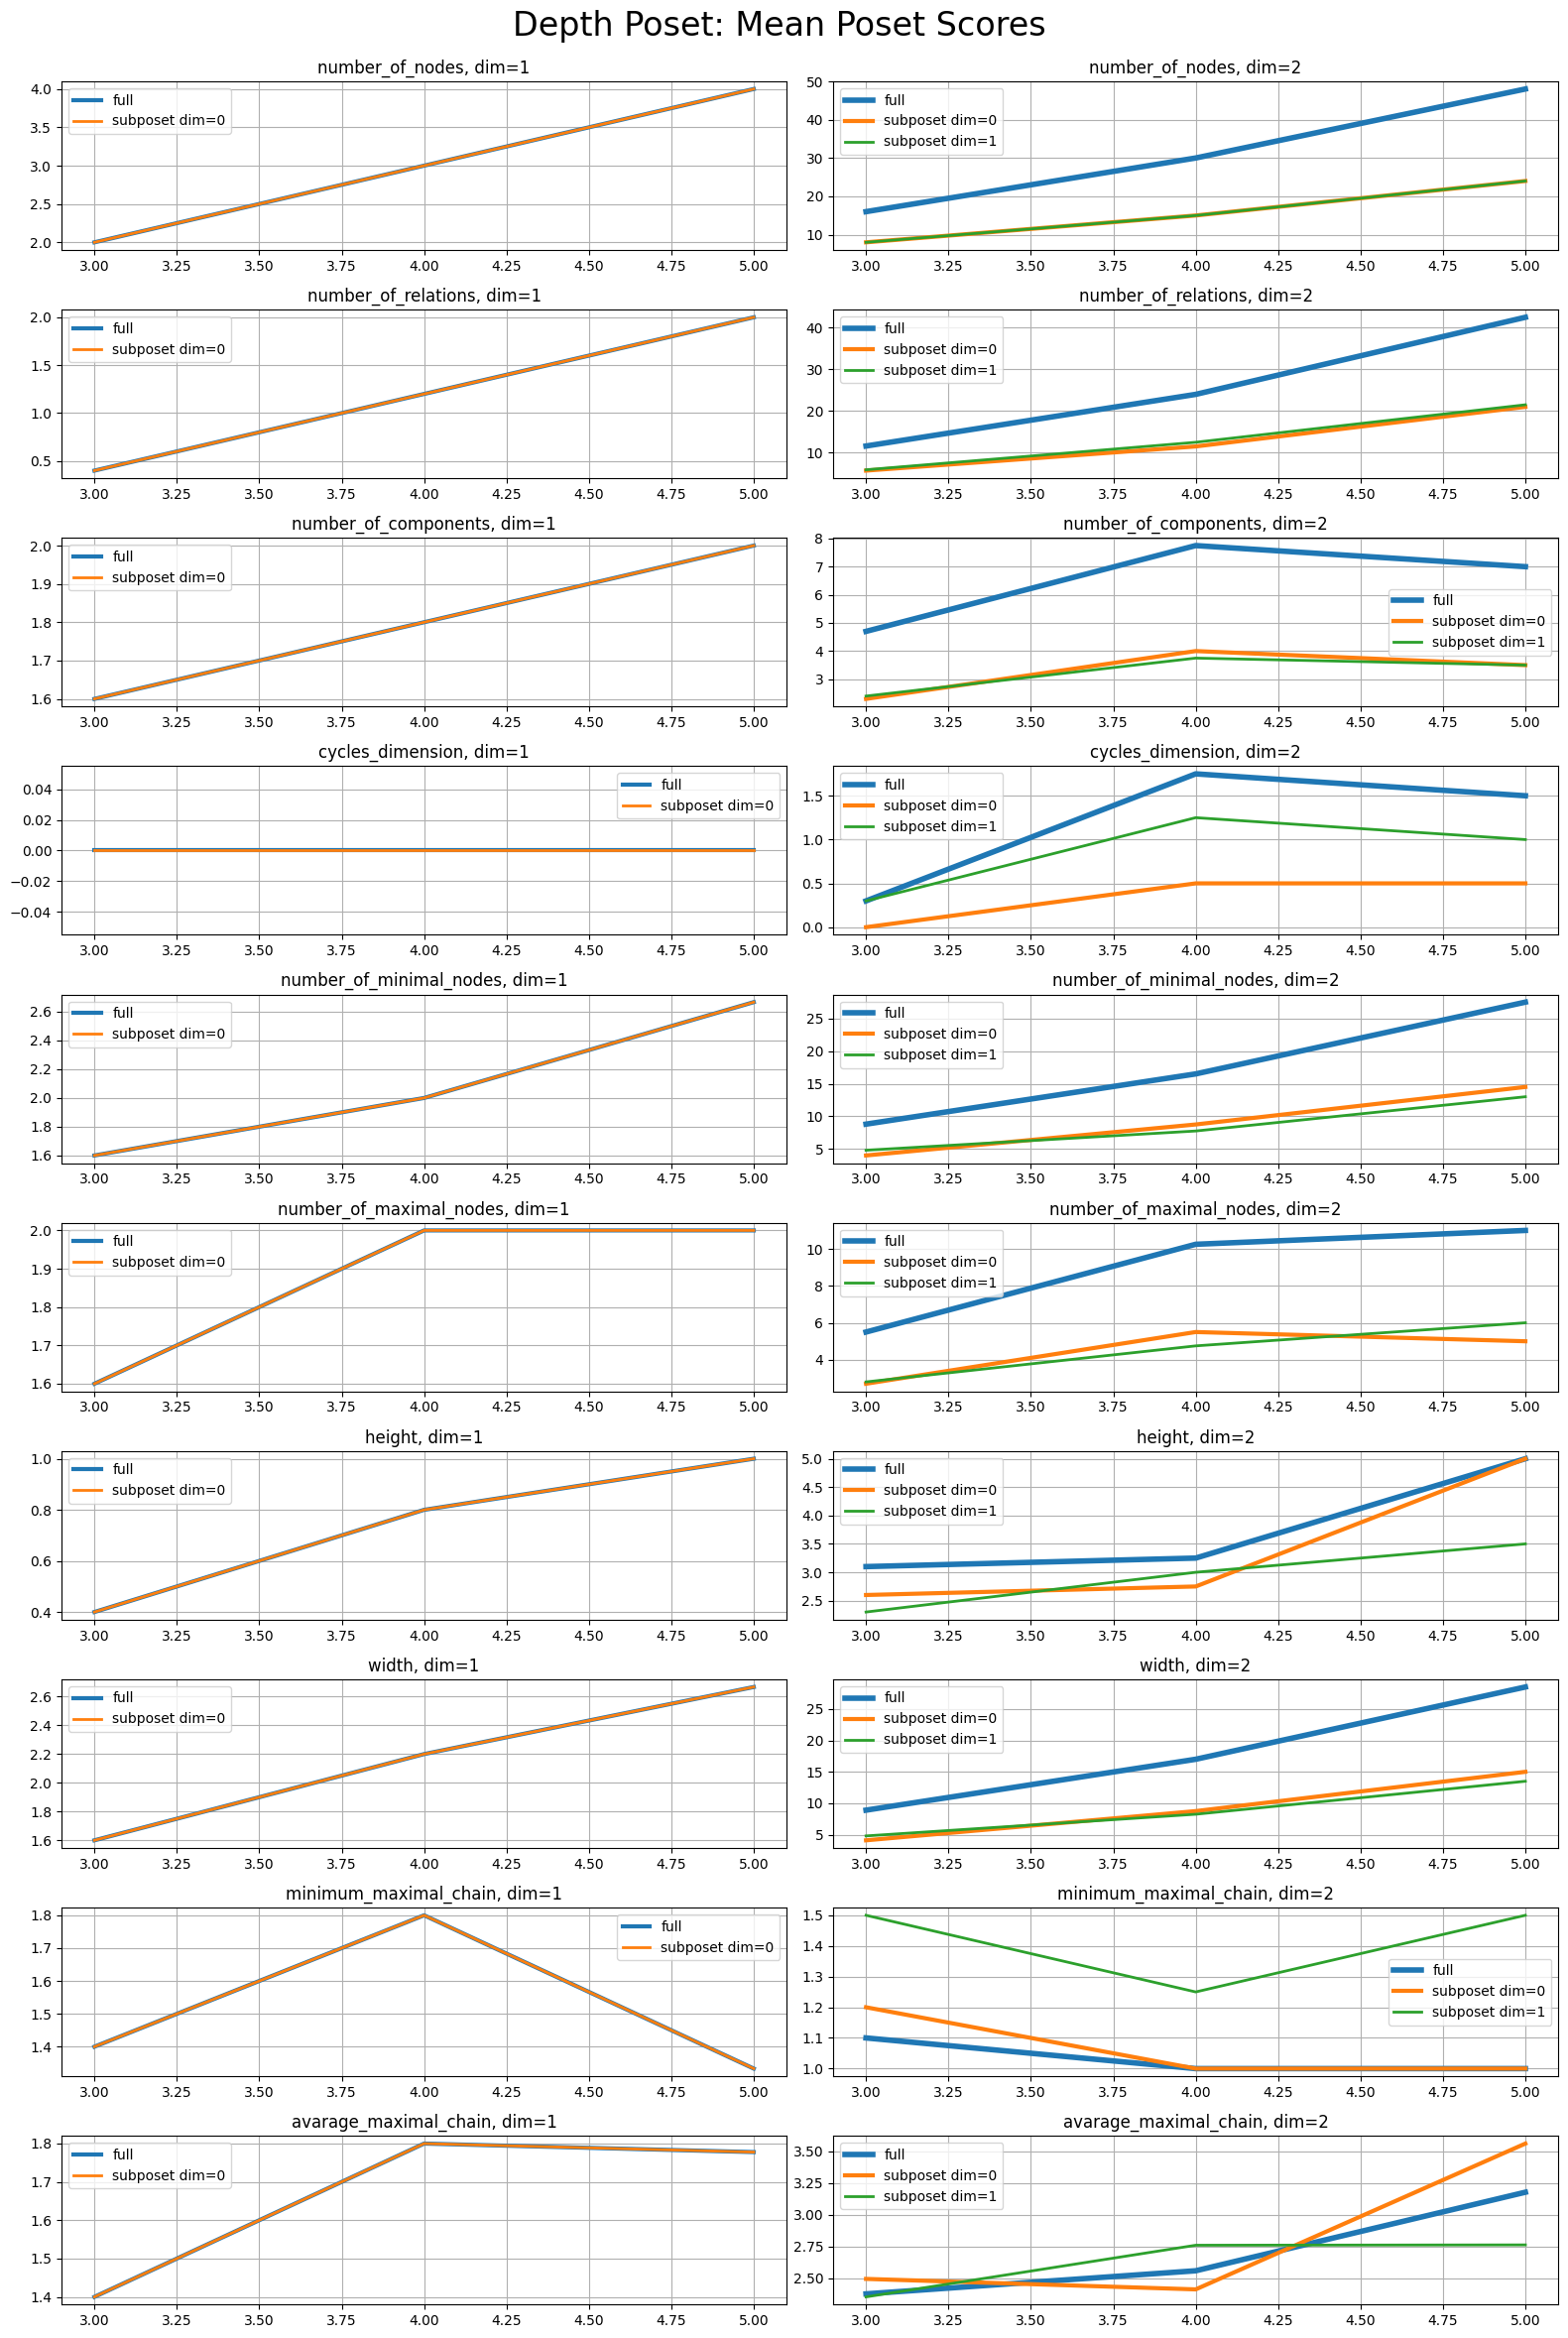

In [11]:
score_cols = interesting_poset_scores_names
max_dim = df_poset_scores['dim'].max()

fig, axs = plt.subplots(len(score_cols), max_dim)

# define the dataframe with interesting objects
objects = ['full'] + [f'subposet dim={dim}' for dim in range(max_dim + 1)]
df_objects = df_poset_scores[df_poset_scores['object'].isin(objects)]

fig.suptitle('Depth Poset: Mean Poset Scores', fontsize=24)
fig.set_figwidth(16)
fig.set_figheight(24)

for iscore, score in enumerate(score_cols):
    for dim in range(1, max_dim + 1):
        title = f'{score}, dim={dim}'
        axs[iscore, dim - 1].set_title(title)
        #df_use = df_poset_scores[df_poset_scores['dim'] == dim][['n', 'object', score]].groupby(['n', 'object']).mean().reset_index().pivot(columns='object', index='n', values=score)
        df_use = df_objects[df_objects['dim'] == dim][['n', 'object', score]].groupby(['n', 'object']).mean().reset_index().pivot(columns='object', index='n', values=score)
        for icol, col in enumerate(df_use.columns):
            axs[iscore, dim - 1].plot(df_use.index, df_use[col], label=col, linewidth=(len(df_use.columns) + 1 - icol))
        axs[iscore, dim - 1].legend()
        axs[iscore, dim - 1].grid(True)
        
plt.tight_layout()
plt.subplots_adjust(top=0.95)

plt.savefig('raports/pics/torus scores - mean poset scores.png')

# Plot Node Scores

In [12]:
from src import node_scores

In [13]:
df_node_scores = [pd.DataFrame(i['node scores']) for i in ls]
for i in range(len(df_node_scores)):
    df_node_scores[i].insert(0, 'index', value=i)
df_node_scores = pd.concat(df_node_scores)


df_node_scores = df_cases[['index', 'n', 'dim']].join(df_node_scores.set_index('index'), on='index').reset_index(drop=True)

print(f'df_node_scores.shape = {df_node_scores.shape}')
df_node_scores.head()

df_node_scores.shape = (1758, 14)


,index,n,dim,object,node,ancestors_cycles_dimension,ancestors_height,ancestors_number,ancestors_width,incomparable_number,successors_cycles_dimension,successors_height,successors_number,successors_width
0,0,3,2,full,"(0, 2),((2,2),(0,2))",0,0,0,0,12,0,2,3,1
1,0,3,2,subposet dim=0,"(0, 2),((2,2),(0,2))",0,0,0,0,4,0,2,3,1
2,0,3,2,column reduction,"(0, 2),((2,2),(0,2))",0,0,0,0,15,0,0,0,0
3,0,3,2,column reduction subposet dim=0,"(0, 2),((2,2),(0,2))",0,0,0,0,7,0,0,0,0
4,0,3,2,row reduction,"(0, 2),((2,2),(0,2))",0,0,0,0,12,0,2,3,1


In [14]:
interesting_node_scores = [node_scores.ancestors_number,
                           node_scores.ancestors_height, 
                           node_scores.ancestors_width, 
                           node_scores.ancestors_cycles_dimension, 
                           node_scores.successors_number,
                           node_scores.successors_height,
                           node_scores.successors_width, 
                           node_scores.successors_cycles_dimension, 
                           ]
interesting_node_scores_names = [score.__name__ for score in interesting_node_scores]

for score in interesting_node_scores:
    if not (score.__name__ in df_node_scores.columns):
        df_node_scores[score.__name__] = np.nan

missed_values = df_node_scores[[score.__name__ for score in interesting_node_scores]].isna().sum().sum()
print(f'There are {missed_values} values missed and should be restored.')

with tqdm(total=missed_values) as pbar:
    for i in df_node_scores[df_node_scores[interesting_node_scores_names].isna().any(axis=1)].index:
        if df_node_scores.loc[i, interesting_node_scores_names].isna().any():
            dp = df_cases.loc[df_cases['index'] == df_node_scores.loc[i, 'index'], 'depth poset'].values[0]
            node = df_node_scores.loc[i, 'node']
            if df_node_scores.loc[i, 'object'] != 'full':
                dp_dim = int(df_node_scores.loc[i, 'object'].replace('subposet dim=', ''))
                dp = dp.subposet_dim(dp_dim)
            for score in interesting_node_scores:
                if pd.isna(df_node_scores.loc[i, score.__name__]):
                    df_node_scores.loc[i, score.__name__] = score(dp, node)
                    pbar.update()
        
print(f'df_node_scores.shape = {df_node_scores.shape}')
df_node_scores.head()

There are 0 values missed and should be restored.


0it [00:00, ?it/s]

df_node_scores.shape = (1758, 14)


,index,n,dim,object,node,ancestors_cycles_dimension,ancestors_height,ancestors_number,ancestors_width,incomparable_number,successors_cycles_dimension,successors_height,successors_number,successors_width
0,0,3,2,full,"(0, 2),((2,2),(0,2))",0,0,0,0,12,0,2,3,1
1,0,3,2,subposet dim=0,"(0, 2),((2,2),(0,2))",0,0,0,0,4,0,2,3,1
2,0,3,2,column reduction,"(0, 2),((2,2),(0,2))",0,0,0,0,15,0,0,0,0
3,0,3,2,column reduction subposet dim=0,"(0, 2),((2,2),(0,2))",0,0,0,0,7,0,0,0,0
4,0,3,2,row reduction,"(0, 2),((2,2),(0,2))",0,0,0,0,12,0,2,3,1


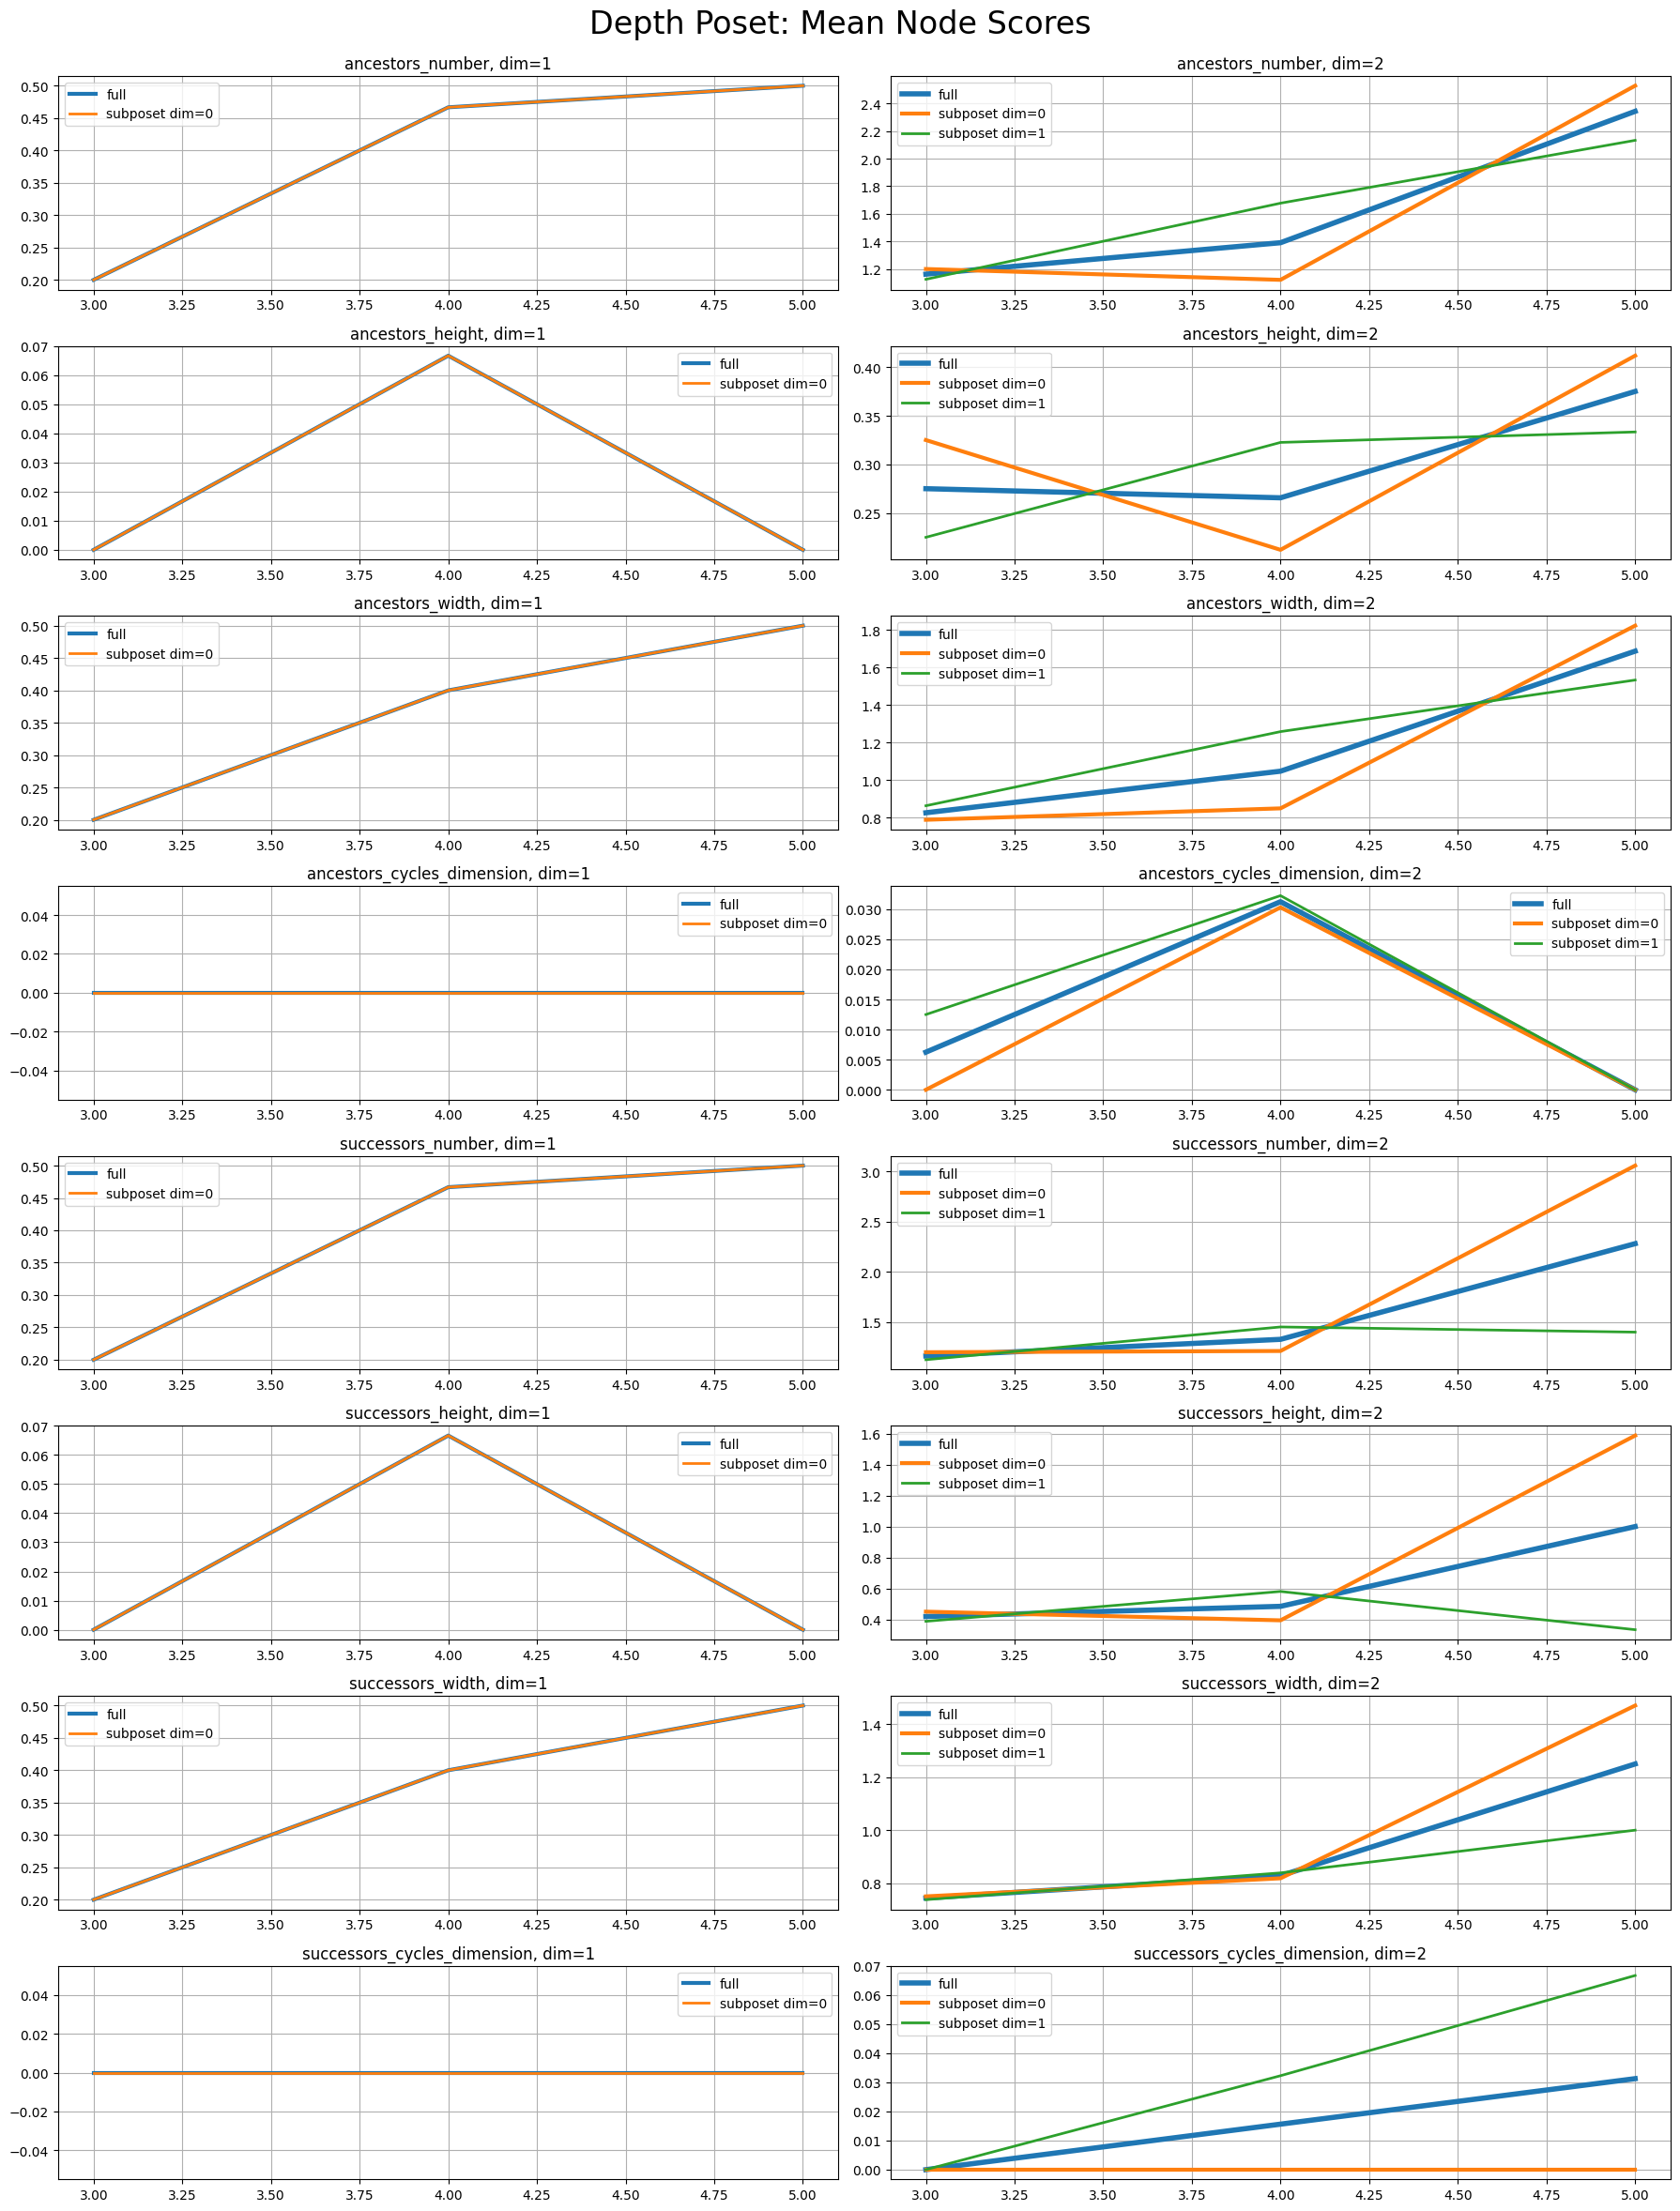

In [15]:
score_cols = interesting_node_scores_names

max_dim = df_node_scores['dim'].max()

# define the dataframe with interesting objects
objects = ['full'] + [f'subposet dim={dim}' for dim in range(max_dim + 1)]
df_objects = df_node_scores[df_node_scores['object'].isin(objects)]

fig, axs = plt.subplots(len(score_cols), max_dim)

fig.suptitle('Depth Poset: Mean Node Scores', fontsize=24)
fig.set_figwidth(18)
fig.set_figheight(24)

for iscore, score in enumerate(score_cols):
    for dim in range(1, max_dim + 1):
        title = f'{score}, dim={dim}'
        axs[iscore, dim - 1].set_title(title)
        df_use = df_objects[df_objects['dim'] == dim][['n', 'object', score]].groupby(['n', 'object']).mean('score').reset_index().pivot(columns='object', index='n', values=score)
        for icol, col in enumerate(df_use.columns):
            axs[iscore, dim - 1].plot(df_use.index, df_use[col], label=col, linewidth=(len(df_use.columns) + 1 - icol))
        axs[iscore, dim - 1].legend()
        axs[iscore, dim - 1].grid(True)
        
plt.tight_layout()
plt.subplots_adjust(top=0.95)

plt.savefig('raports/pics/scores torus - mean node scores.png')